In [ ]:
# Mounting Google Colab with Google Drive

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# Moving to the directory of radialProfile.py so we can import it below

import os
os.chdir("/content/drive/My Drive/deepfake/Frequency/Faces-HQ")

In [ ]:
# Importing Other Required Modules

import cv2
import numpy as np
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle



In [ ]:
# This block of code is to preprocess the data for feeding to the training block
# What it does is : Read a image -> Apply Fourier Transform -> Shift the low freq. to center -> Calculate Magnitude spectrum ->
# ->Calculate azimuthally averaged 1D power spectrum -> Save the data and label in the pickle file
# Once this block is runed and pickle file is saved, we can directly load the next block to read the pickled file and feed to train block

path = ['thispersondoesntexists_10K', '100KFake_10K','Flickr-Faces-HQ_10K', 'celebA-HQ_10K']
labels = [1,1,0,0]
format_file = ['jpg','jpg','jpg', 'jpg']
epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 250
number_iter = 4 * stop
psd1D_total = np.zeros([number_iter, 722])
label_total = np.zeros([number_iter])
iter_ = 0

for z in range(4):
    cont = 0
    psd1D_average_org = np.zeros(722)
    print(path[z])
    
    for filename in glob.glob(path[z]+"/*."+format_file[z]):  
        img = cv2.imread(filename,0)                            # Reading the Image File, in GreyScale
        f = np.fft.fft2(img)                                    # Applying Fourier Transform   
        fshift = np.fft.fftshift(f)                             # Shifting the Origin from Corner to center
        fshift += epsilon                                       # Adding a small constant epsilon 

    # Here, epsilon is added because, while calculating Magnitude Spectrum, np.abs(fshift) can sometime give Zero value and log(0) is undefined.
    # Thus, to remove this error, we added that small constant.

    # On shifting the Origin, the low frequency components comes to center and High freq. component move towards the corner.

        magnitude_spectrum = 20*np.log(np.abs(fshift))          # Calculating Magnitude Spectrum

        
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum) # Calculating the azimuthally averaged 1D power spectrum
        psd1D_total[iter_,:] = psd1D
        label_total[iter_] = labels[z]

        cont+=1
        iter_+=1
        if cont >= stop:
            break

data["data"] = psd1D_total
data["label"] = label_total

output = open('dataset_freq_1000.pkl', 'wb')
pickle.dump(data, output)
output.close()
print("DATA Saved")

In [ ]:
# load feature file {The pickle file saved from above block}
# You can run this cell without running previous if the pkl file is already saved once

pkl_file = open('dataset_freq_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

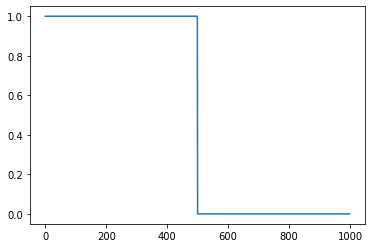

In [ ]:
# We look at the label distribution, to be sure that we have a balanced dataset
# checking weather True (0) and fake (1) faces are balanced or not. We see, both are Balanced.

plt.plot(y)

Text(0, 0.5, 'Power Spectrum')

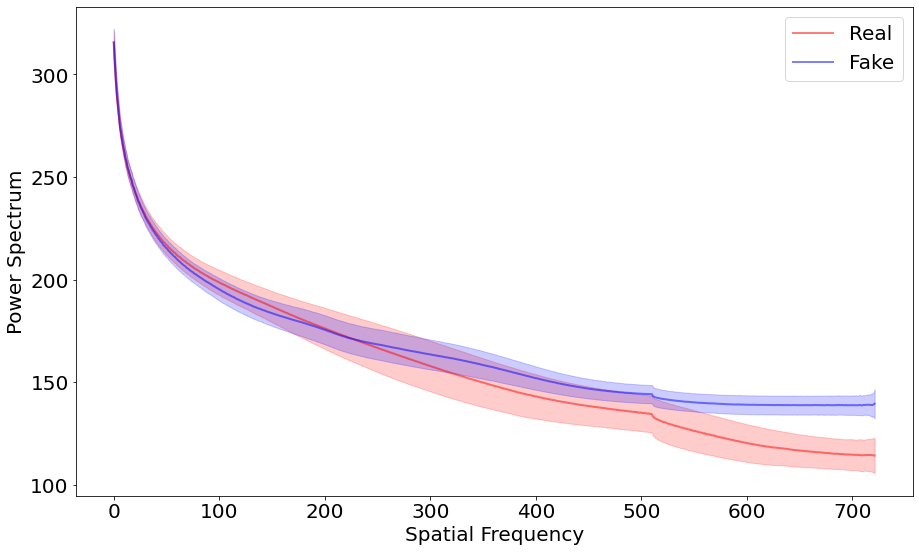

In [ ]:
# We have a look to the spectrum

num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
ax.legend()
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

In [ ]:
# This block is for training the classifier.
# Here, we split the data into training, testing and validation set.
# Once this block is runed and the trained model of the classifier is saved, we should not rerun it.
# We can simply load the saved model.

num = 10
LR = 0
SVM = 0

for z in range(num):
    # read python dict back from the file
    pkl_file = open('dataset_freq_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]         # Keeping All the datas on X
    y = data["label"]        # Keeping All the corresponding labels on y

    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        x_t,x_validation,y_t,y_validation = train_test_split(X_test,y_test,test_size = 0.2)
        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        print('Accuracy on test set: {:.3f}'.format(svclassifier.score(x_t, y_t)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

 
    except:
        num-=1
        print(num)
    
print("Average SVM: "+str(SVM/num))
print("Average LR: "+str(LR/num))

Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Accuracy on test set: 1.000
Average SVM: 1.0
Average LR: 1.0


In [ ]:
# This block of code passes the validation set to the trained model to get it's predicted output and saves to variable 'a'
# y_validation is the actual label of the data
# We compare the value of a and y_validation to see the predicted and actual labels

a = svclassifier.predict(x_validation)
print(a)
print(y_validation)

[1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# This block saves the SVC and Linear model to disk. 

filename1 = 'finalized_svc_model_1.sav'
pickle. dump(svclassifier, open(filename1, 'wb'))

filename2 = 'finalized_lr_model_1.sav'
pickle. dump(logreg, open(filename2, 'wb'))